# The Battle of Neighborhoods
## Segmenting and Clustering Neighborhoods in New York City

### Table of Contents

<font size = 3>
    
1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Data Transformation into a pandas dataframe</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>

### 0. Download all the dependencies that we will be needed

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

### 1. Download and Explore Dataset

This project will be based on a dataset of the previous labs. The original dataset is stored at this location: https://geo.nyu.edu/catalog/nyu_2451_34572. I will run a `wget` command and access the data of the previous lab:

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Accordingly to the previous lab I define a new variable including the relevant features:

In [5]:
neighborhoods_data = newyork_data['features']

### 2. Data Transformation into a *pandas* dataframe

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# loop through the data and fill the dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
# Quick Examination
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### 3. Geocoding New York City

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Map Creation:

In [9]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### 4. Slicing the original dataframe

However, for illustration purposes, I will slice the original dataframe and create a new dataframes for each of the boroughs.

#### 4.a) Bronx Data

In [10]:
bronx_data = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
bronx_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
address = 'Bronx, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bronx are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bronx are 40.8466508, -73.8785937.


In [12]:
# create map of Bronx using latitude and longitude values
map_bronx = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(bronx_data['Latitude'], bronx_data['Longitude'], bronx_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bronx)  
    
map_bronx

#### 4.b) Brooklyn Data

In [13]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [14]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [15]:
# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

#### 4.c) Manhattan Data

In [16]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [17]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [18]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

#### 4.d) Queens Data

In [19]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [20]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7498243, -73.7976337.


In [21]:
# create map of Queens using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

#### 4.e) Staten Island Data

In [22]:
StatenIsland_data = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)
StatenIsland_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


In [23]:
address = 'Staten Island, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Staten Island are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Staten Island are 40.5834557, -74.1496048.


In [24]:
# create map of Staten Island using latitude and longitude values
map_StatenIsland = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(StatenIsland_data['Latitude'], StatenIsland_data['Longitude'], StatenIsland_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_StatenIsland)  
    
map_StatenIsland

In [25]:
StatenIsland_data2 = pd.read_csv('StatenIsland_data2.csv')
StatenIsland_data2.head()

,Borough,Neighborhood,Latitude,Longitude,postalCode
0,Staten Island,St. George,40.644982,-74.079353,10301
1,Staten Island,New Brighton,40.640615,-74.087017,10301
2,Staten Island,Stapleton,40.626928,-74.077902,10304
3,Staten Island,Rosebank,40.615305,-74.069805,10305
4,Staten Island,West Brighton,40.631879,-74.107182,10310


### 5. Data Aggregation on Borough Level

Before analyzing a special Borough, we take some data on the particular Boroughs from US Census Bureau for exploring which Borough could be of interest.

In [26]:
from pandas import ExcelWriter
from pandas import ExcelFile

df = pd.read_excel('NYC_Statistics_from_US_Census_Bureau.xlsx', index_col=0)
df.head()

,Population estimates July 1 2019 (V2019),Land area in square miles 2010,Population per square mile 2010,Median household income (in 2018 dollars) 2014-2018,Per capita income in past 12 months (in 2018 dollars) 2014-2018,Housing units July 1 2018 (V2018),Mean travel time to work (minutes) workers age 16 years+ 2014-2018,Median selected monthly owner costs -with a mortgage 2014-2018,Median selected monthly owner costs -without a mortgage 2014-2018,Median gross rent 2014-2018
Borough,,,,,,,,,,
Bronx,1418207,42.10,32903.6,38085,20850,532487,44.8,2440,755,1176
Brooklyn,2559903,70.82,35369.1,56015,31984,1053767,42.6,2824,878,1374
Manhattan,1628706,22.83,69467.5,82459,72832,886249,32.1,3186,1014,1682
Queens,2253858,108.53,20553.6,64987,30289,865878,44.1,2549,856,1520
Staten Island,476143,58.37,8030.3,79267,34987,181199,44.5,2493,879,1282


#### 5.1 Exploratory Analysis und Visualization

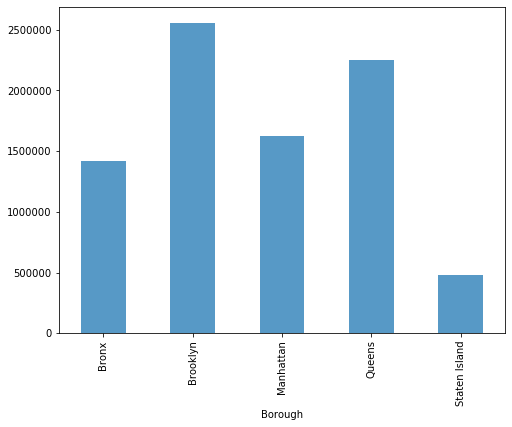

In [27]:
df['Population estimates July 1 2019 (V2019)'].plot(kind='bar',figsize=(8,6),alpha=0.75)

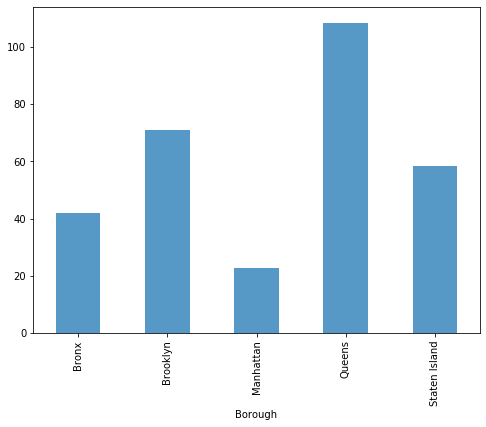

In [28]:
df['Land area in square miles 2010'].plot(kind='bar',figsize=(8,6),alpha=0.75)

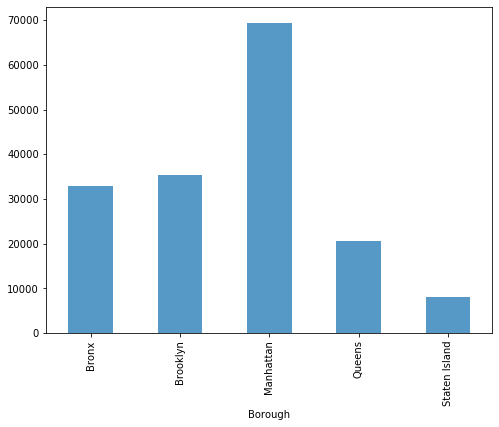

In [29]:
df['Population per square mile 2010'].plot(kind='bar',figsize=(8,6),alpha=0.75)

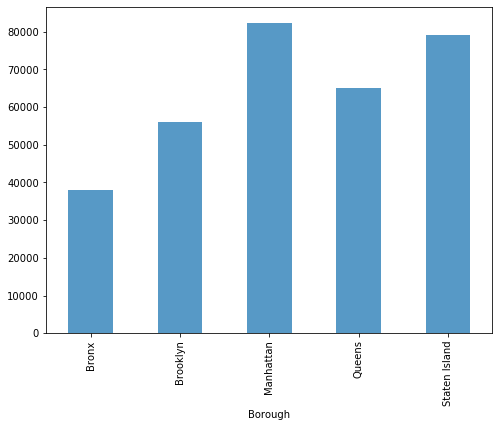

In [30]:
df['Median household income (in 2018 dollars) 2014-2018'].plot(kind='bar',figsize=(8,6),alpha=0.75)

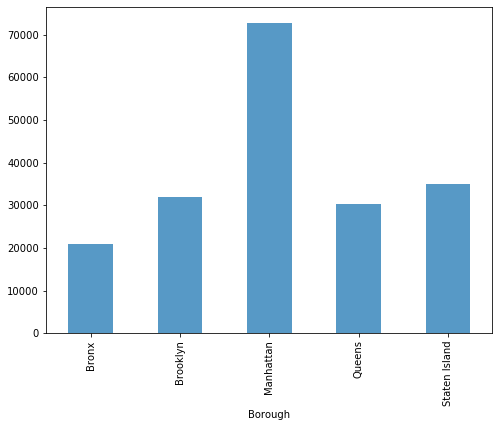

In [31]:
df['Per capita income in past 12 months (in 2018 dollars) 2014-2018'].plot(kind='bar',figsize=(8,6),alpha=0.75)

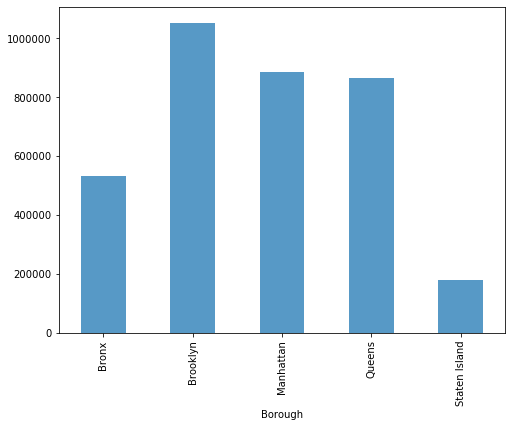

In [32]:
df['Housing units July 1 2018 (V2018)'].plot(kind='bar',figsize=(8,6),alpha=0.75)

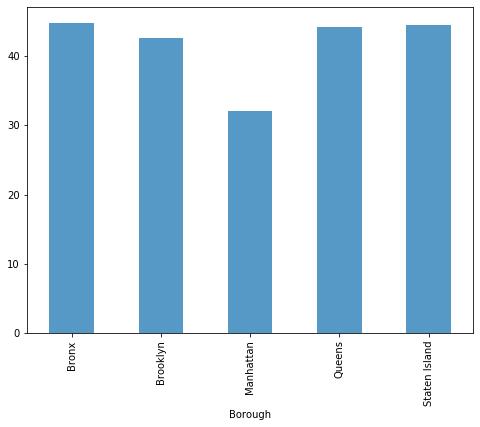

In [33]:
df['Mean travel time to work (minutes) workers age 16 years+ 2014-2018'].plot(kind='bar',figsize=(8,6),alpha=0.75)

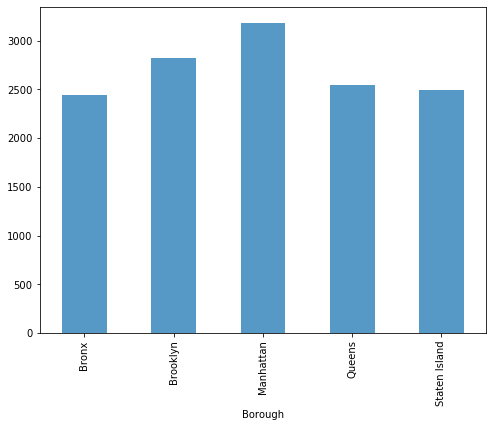

In [34]:
df['Median selected monthly owner costs -with a mortgage 2014-2018'].plot(kind='bar',figsize=(8,6),alpha=0.75)

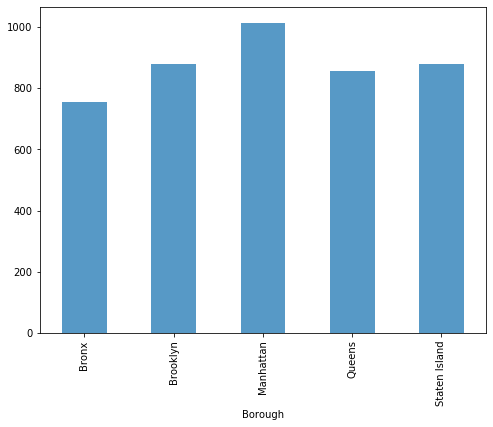

In [35]:
df['Median selected monthly owner costs -without a mortgage 2014-2018'].plot(kind='bar',figsize=(8,6),alpha=0.75)

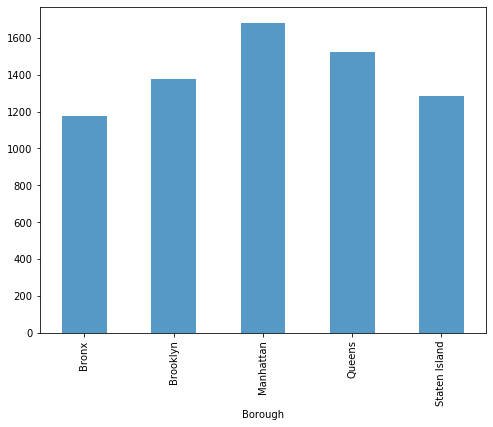

In [36]:
df['Median gross rent 2014-2018'].plot(kind='bar',figsize=(8,6),alpha=0.75)

Well, it looks like Staten Island can be an good opportunity for young families: Population Density is quite low, income level is in a normal range, the travel time to work is not significantly longer than other boroughs and the housing costs are relatively low. So let us explore the neighborhoods of 'Staten Island' to find a new home of a young family.

#### Define Foursquare Credentials and Version

DELETED FOR SECURITY REASONS!

### 6. Exploration of Staten Island Neighborhoods

In [37]:
url = '' # deleted for security reasons
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ec79c9629ce6a001bd1ae60'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 115,
  'suggestedBounds': {'ne': {'lat': 40.60595572250003,
    'lng': -74.1200337411104},
   'sw': {'lat': 40.560955677499976, 'lng': -74.17917585888961}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4be06d0198f2a593ce34c25a',
       'name': 'Greenbelt Nature Center',
       'location': {'address': '501 Brielle Ave',
        'crossStreet': 'Rockland Ave',
        'lat': 40.586615957446355,
        'lng': -

In [38]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id',
       'venue.delivery.id', 'venue.delivery.url',
       'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix',
       'venue.delivery.provider.icon.sizes',
       'venue.delivery.provider.icon.name'],
      dtype='object')

In [38]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [39]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# set filters
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.postalCode', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,venue.name,venue.categories,venue.location.postalCode,venue.location.lat,venue.location.lng
0,Greenbelt Nature Center,"[{'id': '4bf58dd8d48988d159941735', 'name': 'T...",10314,40.586616,-74.146917
1,La Tourette Golf Course,"[{'id': '4bf58dd8d48988d1e6941735', 'name': 'G...",10306,40.575603,-74.147487
2,Trader Joe's,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",10314,40.589997,-74.165715
3,Disney store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",10314,40.581963,-74.166272
4,Primark,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",10314,40.580279,-74.166153


In [41]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,postalCode,lat,lng
0,Greenbelt Nature Center,Trail,10314,40.586616,-74.146917
1,La Tourette Golf Course,Golf Course,10306,40.575603,-74.147487
2,Trader Joe's,Grocery Store,10314,40.589997,-74.165715
3,Disney store,Toy / Game Store,10314,40.581963,-74.166272
4,Primark,Clothing Store,10314,40.580279,-74.166153


In [42]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store            7
Coffee Shop               5
Department Store          4
Sandwich Place            4
Furniture / Home Store    4
Pharmacy                  3
Cosmetics Shop            3
Bank                      3
Italian Restaurant        3
Toy / Game Store          3
Name: categories, dtype: int64

In [43]:
def getNearbyVenues(names, postalCodes, latitudes, longitudes, radius=250):
    
    venues_list=[]
    for name, postalCode, lat, lng in zip(names, postalCodes, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = '' # deleted for security reasons
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            postalCode,
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'postal Code',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',      
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [44]:
StatenIsland_venues = getNearbyVenues(names=StatenIsland_data2['Neighborhood'],
                                   postalCodes=StatenIsland_data2['postalCode'],
                                   latitudes=StatenIsland_data2['Latitude'],
                                   longitudes=StatenIsland_data2['Longitude']
                                  )

St. George
New Brighton
Stapleton
Rosebank
West Brighton
Grymes Hill
Todt Hill
South Beach
Port Richmond
Mariner's Harbor
Port Ivory
Castleton Corners
New Springville
Travis
New Dorp
Oakwood
Great Kills
Eltingville
Annadale
Woodrow
Tottenville
Tompkinsville
Silver Lake
Sunnyside
Park Hill
Westerleigh
Graniteville
Arlington
Arrochar
Grasmere
Old Town
Dongan Hills
Midland Beach
Grant City
New Dorp Beach
Bay Terrace
Huguenot
Pleasant Plains
Butler Manor
Charleston
Rossville
Arden Heights
Greenridge
Heartland Village
Chelsea
Bloomfield
Bulls Head
Richmond Town
Shore Acres
Clifton
Concord
Emerson Hill
Randall Manor
Howland Hook
Elm Park
Manor Heights
Willowbrook
Sandy Ground
Egbertville
Prince's Bay
Lighthouse Hill
Richmond Valley
Fox Hills


In [45]:
StatenIsland_venues.head()

,Neighborhood,postal Code,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. George,10301,40.644982,-74.079353,Greenbelt Nature Center,40.586616,-74.146917,Trail
1,St. George,10301,40.644982,-74.079353,La Tourette Golf Course,40.575603,-74.147487,Golf Course
2,St. George,10301,40.644982,-74.079353,Trader Joe's,40.589997,-74.165715,Grocery Store
3,St. George,10301,40.644982,-74.079353,Disney store,40.581963,-74.166272,Toy / Game Store
4,St. George,10301,40.644982,-74.079353,Primark,40.580279,-74.166153,Clothing Store


In [46]:
# Unfortunately there was an error. So I prepare the table with MS Excel and upload it hereby
StatenIsland_venues2 = pd.read_excel('StatenIsland_venues2.xlsx', index_col=0)
StatenIsland_venues2.head()

,postalCode,Venue,Venue Category
Neighborhood,,,
Heartland Village,10314,1001 Nights Cafe,Hookah Bar
New Springville,10314,AMC Dine-In Staten Island 11,Movie Theater
New Springville,10314,American Eagle Outfitters,Clothing Store
New Springville,10314,angelinas kitchen,Italian Restaurant
New Springville,10314,Apple Staten Island,Electronics Store


In [47]:
print('There are {} uniques categories.'.format(len(StatenIsland_venues2['Venue Category'].unique())))
StatenIsland_venues2.groupby('Neighborhood').count().head()

There are 59 uniques categories.


,postalCode,Venue,Venue Category
Neighborhood,,,
Annadale,1,1,1
Bulls Head,3,3,3
Charleston,5,5,5
Dongan Hills,1,1,1
Egbertville,1,1,1


### 7. Neighborhood Analysis

In [48]:
# one hot encoding
StatenIsland_onehot = pd.get_dummies(StatenIsland_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
StatenIsland_onehot['Neighborhood'] = StatenIsland_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [StatenIsland_onehot.columns[-1]] + list(StatenIsland_onehot.columns[:-1])
StatenIsland_onehot = StatenIsland_onehot[fixed_columns]
StatenIsland_grouped = StatenIsland_onehot.groupby('Neighborhood').mean().reset_index()

In [71]:
# Unfortunately there was an error. So I prepare the table with MS Excel and upload it hereby
StatenIsland_onehot = pd.read_excel('StatenIsland_onehot.xlsx', index_col=0)
StatenIsland_onehot.head()

,Accessories Store,Art Museum,Bagel Shop,Bakery,Bank,Baseball Field,Big Box Store,Bookstore,Burger Joint,Campground,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Department Store,Discount Store,Donut Shop,Electronics Store,Fast Food Restaurant,Food & Drink Shop,Food Service,French Restaurant,Furniture / Home Store,Gastropub,Golf Course,Grocery Store,Gym / Fitness Center,Health & Beauty Service,History Museum,Hookah Bar,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Lingerie Store,Liquor Store,Men's Store,Mexican Restaurant,Mobile Phone Shop,Movie Theater,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Restaurant,Sandwich Place,Shoe Store,Shopping Mall,Spa,Sporting Goods Shop,Steakhouse,Supplement Shop,Toy / Game Store,Trail,Video Game Store,Warehouse Store,Women's Store
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Annadale,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bulls Head,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Charleston,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Dongan Hills,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Egbertville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [72]:
StatenIsland_grouped = StatenIsland_onehot.groupby('Neighborhood').mean().reset_index()
StatenIsland_grouped.head()

,Neighborhood,Accessories Store,Art Museum,Bagel Shop,Bakery,Bank,Baseball Field,Big Box Store,Bookstore,Burger Joint,Campground,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Department Store,Discount Store,Donut Shop,Electronics Store,Fast Food Restaurant,Food & Drink Shop,Food Service,French Restaurant,Furniture / Home Store,Gastropub,Golf Course,Grocery Store,Gym / Fitness Center,Health & Beauty Service,History Museum,Hookah Bar,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Lingerie Store,Liquor Store,Men's Store,Mexican Restaurant,Mobile Phone Shop,Movie Theater,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Restaurant,Sandwich Place,Shoe Store,Shopping Mall,Spa,Sporting Goods Shop,Steakhouse,Supplement Shop,Toy / Game Store,Trail,Video Game Store,Warehouse Store,Women's Store
0,Annadale,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bulls Head,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Charleston,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,Dongan Hills,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Egbertville,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [74]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = StatenIsland_grouped['Neighborhood']

for ind in np.arange(StatenIsland_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(StatenIsland_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Annadale,Bagel Shop,Women's Store,Department Store,Gym / Fitness Center,Grocery Store
1,Bulls Head,Baseball Field,Chinese Restaurant,Playground,Women's Store,Discount Store
2,Charleston,Cosmetics Shop,Bakery,Health & Beauty Service,Supplement Shop,Pet Store
3,Dongan Hills,Bank,Women's Store,Department Store,Gym / Fitness Center,Grocery Store
4,Egbertville,Park,Women's Store,History Museum,Gym / Fitness Center,Grocery Store


### 7. Clustering Neighborhoods

In [75]:
# set number of clusters
kclusters = 7

StatenIsland_grouped_clustering = StatenIsland_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(StatenIsland_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:60] 

array([2, 3, 4, 2, 2, 2, 0, 2, 2, 6, 5, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2],
      dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [76]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

StatenIsland_merged = StatenIsland_data

# merge to add latitude/longitude for each neighborhood
StatenIsland_merged = StatenIsland_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

StatenIsland_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Staten Island,St. George,40.644982,-74.079353,2.0,Ice Cream Shop,Clothing Store,Coffee Shop,Women's Store,Discount Store
1,Staten Island,New Brighton,40.640615,-74.087017,NaN,NaN,NaN,NaN,NaN,NaN
2,Staten Island,Stapleton,40.626928,-74.077902,NaN,NaN,NaN,NaN,NaN,NaN
3,Staten Island,Rosebank,40.615305,-74.069805,NaN,NaN,NaN,NaN,NaN,NaN
4,Staten Island,West Brighton,40.631879,-74.107182,2.0,Donut Shop,Women's Store,Department Store,Gym / Fitness Center,Grocery Store


In [77]:
df9999 = StatenIsland_merged
df9999.to_csv(r'StatenIsland_merged2.csv')

In [78]:
# Unfortunately there was an error. So I prepare the table with MS Excel and upload it hereby
StatenIsland_merged = pd.read_excel('StatenIsland_merged.xlsx', index_col=0)
StatenIsland_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Staten Island,St. George,40.644982,-74.079353,2,Ice Cream Shop,Clothing Store,Coffee Shop,Women's Store,Discount Store
4,Staten Island,West Brighton,40.631879,-74.107182,2,Donut Shop,Women's Store,Department Store,Gym / Fitness Center,Grocery Store
12,Staten Island,New Springville,40.594252,-74.164960,1,Clothing Store,Toy / Game Store,Furniture / Home Store,Cosmetics Shop,Department Store
16,Staten Island,Great Kills,40.549480,-74.149324,2,Bakery,Women's Store,Department Store,Gym / Fitness Center,Grocery Store
17,Staten Island,Eltingville,40.542231,-74.164331,0,Pharmacy,Video Game Store,Cosmetics Shop,Grocery Store,Golf Course


Finally, let's visualize the resulting clusters

In [80]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(StatenIsland_merged['Latitude'], StatenIsland_merged['Longitude'], StatenIsland_merged['Neighborhood'], StatenIsland_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 7.1 Cluster Exploration

#### Cluster 1

In [58]:
StatenIsland_merged.loc[StatenIsland_merged['Cluster Labels'] == 0, StatenIsland_merged.columns[[1] + list(range(5, StatenIsland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,Eltingville,Pharmacy,Video Game Store,Cosmetics Shop,Grocery Store,Golf Course


#### Cluster 2

In [59]:
StatenIsland_merged.loc[StatenIsland_merged['Cluster Labels'] == 1, StatenIsland_merged.columns[[1] + list(range(5, StatenIsland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,New Springville,Clothing Store,Toy / Game Store,Furniture / Home Store,Cosmetics Shop,Department Store


#### Cluster 3

In [60]:
StatenIsland_merged.loc[StatenIsland_merged['Cluster Labels'] == 2, StatenIsland_merged.columns[[1] + list(range(5, StatenIsland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,St. George,Ice Cream Shop,Clothing Store,Coffee Shop,Women's Store,Discount Store
4,West Brighton,Donut Shop,Women's Store,Department Store,Gym / Fitness Center,Grocery Store
16,Great Kills,Bakery,Women's Store,Department Store,Gym / Fitness Center,Grocery Store
18,Annadale,Bagel Shop,Women's Store,Department Store,Gym / Fitness Center,Grocery Store
20,Tottenville,Bank,Women's Store,Department Store,Gym / Fitness Center,Grocery Store
21,Tompkinsville,Gym / Fitness Center,Fast Food Restaurant,Women's Store,Department Store,Grocery Store
26,Graniteville,Coffee Shop,Women's Store,Department Store,Gym / Fitness Center,Grocery Store
31,Dongan Hills,Bank,Women's Store,Department Store,Gym / Fitness Center,Grocery Store
32,Midland Beach,Paper / Office Supplies Store,Discount Store,Women's Store,History Museum,Gym / Fitness Center
34,New Dorp Beach,Supplement Shop,Furniture / Home Store,Burger Joint,Sandwich Place,Women's Store


#### Cluster 4

In [61]:
StatenIsland_merged.loc[StatenIsland_merged['Cluster Labels'] == 3, StatenIsland_merged.columns[[1] + list(range(5, StatenIsland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
46,Bulls Head,Baseball Field,Chinese Restaurant,Playground,Women's Store,Discount Store


#### Cluster 5

In [62]:
StatenIsland_merged.loc[StatenIsland_merged['Cluster Labels'] == 4, StatenIsland_merged.columns[[1] + list(range(5, StatenIsland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
39,Charleston,Cosmetics Shop,Bakery,Health & Beauty Service,Supplement Shop,Pet Store


#### Cluster 6

In [63]:
StatenIsland_merged.loc[StatenIsland_merged['Cluster Labels'] == 5, StatenIsland_merged.columns[[1] + list(range(5, StatenIsland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
60,Lighthouse Hill,Italian Restaurant,Art Museum,Golf Course,Spa,Women's Store


#### Cluster 7

In [64]:
StatenIsland_merged.loc[StatenIsland_merged['Cluster Labels'] == 6, StatenIsland_merged.columns[[1] + list(range(5, StatenIsland_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
43,Heartland Village,Hookah Bar,Shoe Store,Furniture / Home Store,Food & Drink Shop,Liquor Store


### Appendix: Cluster Analysis for NYC Statistics from US Census Bureau

In [65]:
StatenIslandStats = pd.read_excel('StatenIsland_StatisticsNormalized.xlsx', index_col=0)
StatenIslandStats.head()

,Borough,Latitude,Longitude,Population,Land area,Population per square mile,Median household income,Per capita income,Housing units,Mean travel time to work,owner costs with a mortgage,owner costs without a mortgage,Median gross rent
0,Bronx,40.846651,-73.878594,0.554008,0.387911,0.473655,0.461866,0.286275,0.505318,1.000000,0.765851,0.744576,0.699168
1,Brooklyn,40.650104,-73.949582,1.000000,0.652538,0.509146,0.679307,0.439148,1.000000,0.950893,0.886378,0.865878,0.816885
2,Manhattan,40.789624,-73.959894,0.636237,0.210357,1.000000,1.000000,1.000000,0.841029,0.716518,1.000000,1.000000,1.000000
3,Queens,40.749824,-73.797634,0.880447,1.000000,0.295874,0.788113,0.415875,0.821698,0.984375,0.800063,0.844181,0.903686
4,Staten Island,40.583456,-74.149605,0.186000,0.537824,0.115598,0.961290,0.480380,0.171954,0.993304,0.782486,0.866864,0.762188


In [66]:
# set number of clusters
kclusters = 4

StatenIslandStats_clustering = StatenIslandStats.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(StatenIslandStats_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:60] 

array([3, 1, 2, 1, 0], dtype=int32)

In [67]:
# add clustering labels
StatenIslandStats_clustering.insert(0, 'Cluster Labels', kmeans.labels_)

StatenIslandStats_clustering.head()

,Cluster Labels,Latitude,Longitude,Population,Land area,Population per square mile,Median household income,Per capita income,Housing units,Mean travel time to work,owner costs with a mortgage,owner costs without a mortgage,Median gross rent
0,3,40.846651,-73.878594,0.554008,0.387911,0.473655,0.461866,0.286275,0.505318,1.000000,0.765851,0.744576,0.699168
1,1,40.650104,-73.949582,1.000000,0.652538,0.509146,0.679307,0.439148,1.000000,0.950893,0.886378,0.865878,0.816885
2,2,40.789624,-73.959894,0.636237,0.210357,1.000000,1.000000,1.000000,0.841029,0.716518,1.000000,1.000000,1.000000
3,1,40.749824,-73.797634,0.880447,1.000000,0.295874,0.788113,0.415875,0.821698,0.984375,0.800063,0.844181,0.903686
4,0,40.583456,-74.149605,0.186000,0.537824,0.115598,0.961290,0.480380,0.171954,0.993304,0.782486,0.866864,0.762188


In [69]:
# create map
map_clusters = folium.Map(location=[40.690550, -73.976559], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(StatenIslandStats_clustering['Latitude'], StatenIslandStats_clustering['Longitude'], StatenIslandStats_clustering['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=75,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.25).add_to(map_clusters)
    
map_clusters

#### Cluster Exploration

#### a) Cluster 1 = Staten Island

In [91]:
StatenIslandStats_clustering.loc[StatenIslandStats_clustering['Cluster Labels'] == 0]

,Cluster Labels,Latitude,Longitude,Population,Land area,Population per square mile,Median household income,Per capita income,Housing units,Mean travel time to work,owner costs with a mortgage,owner costs without a mortgage,Median gross rent
4,0,40.583456,-74.149605,0.186,0.537824,0.115598,0.96129,0.48038,0.171954,0.993304,0.782486,0.866864,0.762188


#### b) Cluster 2 = Brooklyn & Queens

In [92]:
StatenIslandStats_clustering.loc[StatenIslandStats_clustering['Cluster Labels'] == 1]

,Cluster Labels,Latitude,Longitude,Population,Land area,Population per square mile,Median household income,Per capita income,Housing units,Mean travel time to work,owner costs with a mortgage,owner costs without a mortgage,Median gross rent
1,1,40.650104,-73.949582,1.000000,0.652538,0.509146,0.679307,0.439148,1.000000,0.950893,0.886378,0.865878,0.816885
3,1,40.749824,-73.797634,0.880447,1.000000,0.295874,0.788113,0.415875,0.821698,0.984375,0.800063,0.844181,0.903686


#### c) Cluster 3 = Manhattan

In [93]:
StatenIslandStats_clustering.loc[StatenIslandStats_clustering['Cluster Labels'] == 2]

,Cluster Labels,Latitude,Longitude,Population,Land area,Population per square mile,Median household income,Per capita income,Housing units,Mean travel time to work,owner costs with a mortgage,owner costs without a mortgage,Median gross rent
2,2,40.789624,-73.959894,0.636237,0.210357,1.0,1.0,1.0,0.841029,0.716518,1.0,1.0,1.0


#### d) Cluster 4 = Bronx

In [94]:
StatenIslandStats_clustering.loc[StatenIslandStats_clustering['Cluster Labels'] == 3]

,Cluster Labels,Latitude,Longitude,Population,Land area,Population per square mile,Median household income,Per capita income,Housing units,Mean travel time to work,owner costs with a mortgage,owner costs without a mortgage,Median gross rent
0,3,40.846651,-73.878594,0.554008,0.387911,0.473655,0.461866,0.286275,0.505318,1.0,0.765851,0.744576,0.699168
